# Cеминар 7: От деревьев к случайному лесу

## Решающее дерево

Мотивацию построения алгоритма случайного леса (Random Forest) удобно рассматривать, показывая проблемы решающих деревьев. Начнём с построения решающего дерева.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = pd.DataFrame(data=housing["data"], columns=housing["feature_names"])
y = housing["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# TODO: обучите решающее дерево без ограничений на тренировочной выборке


# TODO: рассчитайте MSE на тренировочной и тестовой выборках



Как мы обсуждали на предыдущем семинаре, такое дерево окажется сильно переобученным. Постараемся исправить это. На лекции мы обсуждали, что один из способов борьбы с переобучением – построение композиций моделей. На этом семинаре мы рассмотрим построение композиций при помощи бэггинга.

### Бэггинг

Вспомним суть алгоритма:

1. Обучаем много деревьев на бутстрапированных подвыборках исходной выборки независимо друг от друга. Бутстрапированную подвыборку строим при помощи выбора $N$ (размер исходной выборки) наблюдений из исходной выборки с возвращением. 

2. Усредняем предсказания всех моделей (например, берём арифметическое среднее). 


In [5]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

base_tree = DecisionTreeRegressor(random_state = 123)

# TODO: обучим бэггинг с 20 деревьями, каждое из которых строится без ограничений

regr = BaggingRegressor(estimator=base_tree, n_estimators=20, random_state=123).fit(X_train, y_train)

Как мы видим, по сравнению с единичным деревом смещение практически не изменилось, но дисперсия уменьшилась в несколько раз!

Посмотрим, как это отразилось на среднеквадратичной ошибке.

In [6]:
# TODO: рассчитайте MSE на тренировочной и тестовой выборках для бэггинга

print(mean_squared_error(regr.predict(X_test), y_test))

0.2591304770121025


Среднеквадратичная ошибка на тренировочной выборке больше не равна 0, а на тестовой – уменьшилась, что говорит о том, что мы успешно победили переобучение единичного решающего дерева. 

Можем ли мы снизить переобучение ещё сильнее? Можем!

## Случайный лес

При построении каждого дерева в бэггинге в ходе создания очередного узла будем выбирать случайный набор признаков, на основе которых производится разбиение.Такой алгоритм назвывается **случайным лесом** (Random Forest). 

По сравнению с единичным деревом к параметрам случайного леса добавляются:
- `max_features` – число признаков, на основе которых проводятся разбиения при построении дерева.

- `n_estimators` – число деревьев. 

Естественно, все параметры, относящиеся к единичному дереву, сохраняются для случайного леса.

In [10]:
from sklearn.ensemble import RandomForestRegressor

# TODO: обучите случайный лес с 20 деревьями, каждое из которых строится без ограничений
rf = RandomForestRegressor(n_estimators=20, random_state=123).fit(X_train, y_train)

# TODO: рассчитайте MSE на тренировочной и тестовой выборках для случайного леса
print(mean_squared_error(rf.predict(X_test), y_test))


0.259247465755396


Ошибка на тренировочной выборке увеличилась, а на тестовой – уменьшилась, что означает, что мы добились нашей цели в борьбе с переобученными деревьями!

## Особенности случайного леса

### Число деревьев и "Случайный лес не переобучается"

В своём [блоге](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks) Лео Бриман (Leo Breiman), создатель случайного леса, написал следующее:

> Random forest does not overfit. You can run as many trees as you want.

**Обратите внимание:** как говорилось на лекции, случайный лес не переобучается именно с ростом числа деревьев (за счёт совместной работы бэггинга и использования случайных подпространств), но не в принципе. Посмотрим на поведение случайного леса при росте числа деревьев.

In [11]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = pd.DataFrame(data=housing["data"], columns=housing["feature_names"])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

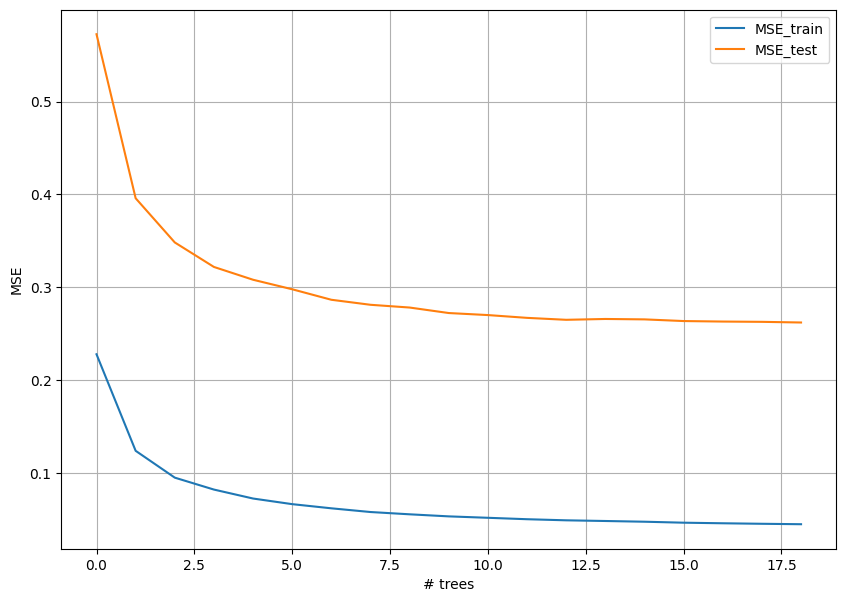

In [12]:
import matplotlib.pyplot as plt

n_trees = 20
train_loss = []
test_loss = []

for i in range(1, n_trees):
    rf = RandomForestRegressor(n_estimators = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('# trees')
plt.legend();

Как и ожидалось, по достижении некоторого числа деревьев обе ошибки практически не изменяются, то есть переобучения при росте числа деревьев не происходит.

Однако практика показывает, что при изменении какого-нибудь другого параметра на реальных данных переобучение может произойти: [пример 1](https://datascience.stackexchange.com/questions/1028/do-random-forest-overfit), [пример 2](https://mljar.com/blog/random-forest-overfitting/). Например, случайный лес с ограниченными по глубине деревьями может предсказывать более точно, чем лес без ограничений. 

В нашем же случае случайный лес, скорее, лишь страдает от регуляризации. Например, посмотрим на поведение модели при изменении максимальной глубины деревьев (поэксперементируйте с другими параметрами).

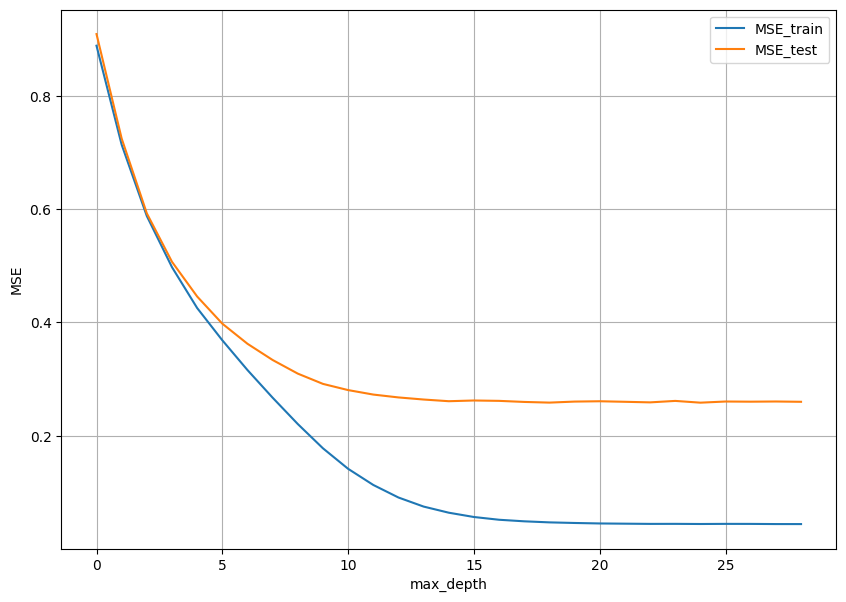

In [ ]:
max_depth = 30
train_loss = []
test_loss = []

for i in range(1, max_depth):
    rf = RandomForestRegressor(n_estimators = 20, max_depth = i, random_state = 123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))
    
plt.figure(figsize = (10, 7))
plt.grid()
plt.plot(train_loss, label = 'MSE_train')
plt.plot(test_loss, label = 'MSE_test')
plt.ylabel('MSE')
plt.xlabel('max_depth')
plt.legend();

Переобучение не наблюдается. Вообще же, как обычно, гиперпараметры случайного леса стоит подбирать на кросс-валидации.

### Out-of-bag-ошибка

Как мы обсудили выше, при построении случайного леса каждое дерево строится на бутстрапированной подвыборке, полученной из исходной обучающей выборки случайным набором с повторениями. Понятно, что некоторые наблюдения попадут в такую подвыборку несколько раз, а некоторые не войдут в неё вообще. Для каждого дерева мы можем рассмотреть объекты, которые не участвовали в обучении и использовать их для валидации.

Усреднённая ошибка на неотобранных образцах по всему случайному лесу называется **out-of-bag-ошибкой**.

In [ ]:
housing = fetch_california_housing()
X = pd.DataFrame(data=housing["data"], columns=housing["feature_names"])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.3,
                                                    random_state = 123,
                                                    shuffle = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

# oob_score_ = R2 на невиденных наблюдениях.
rf = RandomForestRegressor(n_estimators = 100, random_state = 123, oob_score = True)
rf.fit(X_train, y_train)
rf.oob_score_

0.8002726542248801

### Важность признаков

Как и решающие деревья, случайный лес позволяет оценивать важность признаков.

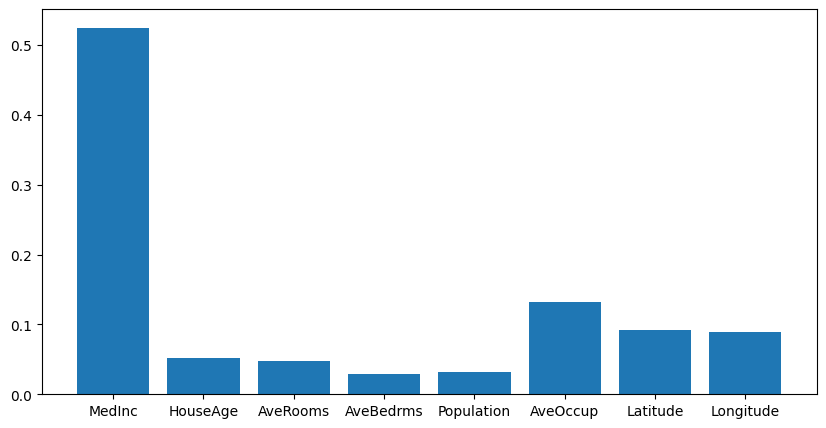

In [15]:
plt.figure(figsize = (10, 5))
plt.bar(housing['feature_names'], rf.feature_importances_);

Будьте осторожны с сильно коррелирующими признаками. Посмотрим, что произойдёт с важностью, если добавить в выборку линейно зависимый признак.

In [16]:
import numpy as np

RM_mc = (np.array(X_train['MedInc']) * 2 + 3).reshape(-1, 1)
X_train_new = np.hstack((X_train, RM_mc))

In [17]:
rf.fit(X_train_new, y_train)

RandomForestRegressor(oob_score=True, random_state=123)

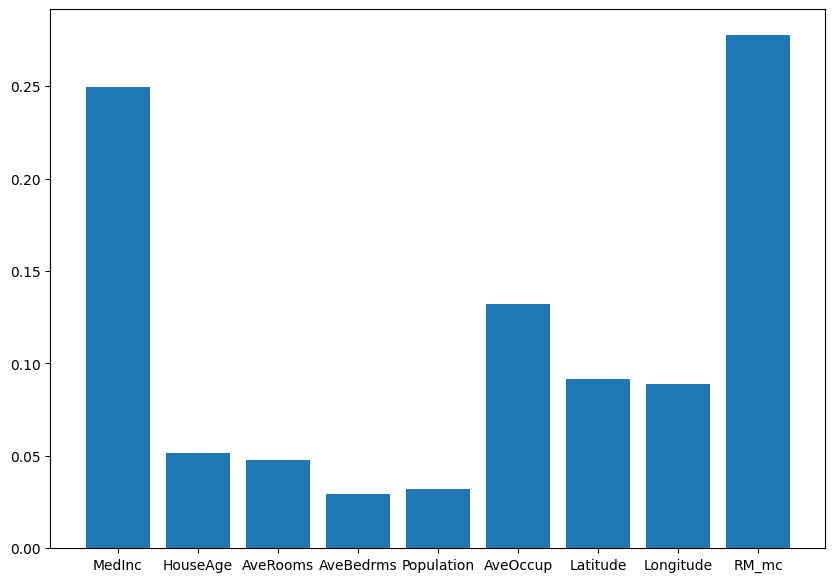

In [18]:
plt.figure(figsize = (10, 7))
names = list(housing['feature_names'])
names.append('RM_mc')
plt.bar(names, rf.feature_importances_);

Важности перераспределились между линейной зависимыми признаками `RM` и `RM_mc`. Не забывайте учитывать корреляции между признаками, если вы используете этот метод для отбора признаков. Также обратите внимание на предупреждение в документации `sklearn`: не стоит использовать этот метод и для признаков, в которых есть много уникальных значений (например, категориальные признаки с небольшим числом категорий). 